In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers


In [2]:
inputs1 = np.load(r"data\inputs_segment0.npy")
targets1 = np.load(r"data\targets_segment0.npy")

inputs2 = np.load(r"data\inputs_segment1.npy")
targets2 = np.load(r"data\targets_segment1.npy")

inputs3 = np.load(r"data\inputs_segment3.npy")
targets3 = np.load(r"data\targets_segment3.npy")

inputs4 = np.load(r"data\inputs_segment4.npy")
targets4 = np.load(r"data\targets_segment4.npy")

print(inputs1.shape)

(71, 15, 15)


In [3]:
inputs0 = np.concatenate((inputs1, inputs2, inputs3, inputs4), axis=0)
print(inputs0.shape)

targets0 = np.concatenate((targets1, targets2, targets3, targets4), axis=0)


kolowosc = targets0[:, [1]].astype("float32")
promien = targets0[:,[0]].astype('float32')

print(kolowosc.shape)

(429, 15, 15)
(429, 1)


(np.float64(-0.5), np.float64(14.5), np.float64(14.5), np.float64(-0.5))

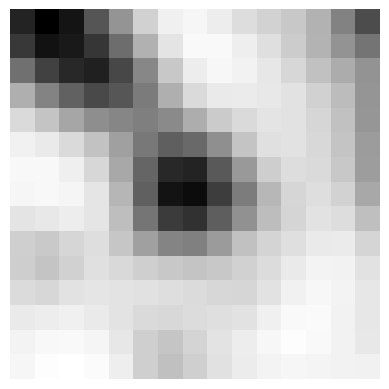

In [4]:
plt.imshow(inputs0[0], cmap="Greys")
plt.axis('off')


(np.float64(-0.5), np.float64(14.5), np.float64(14.5), np.float64(-0.5))

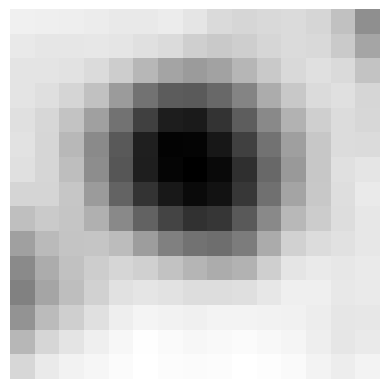

In [5]:
plt.imshow(inputs0[20], cmap="Greys")
plt.axis('off')

In [6]:
print(inputs0[0])

print(inputs0[20])

[[0.43143383 0.46880188 0.44674661 0.38894673 0.31850608 0.25159676
  0.20138532 0.18840146 0.20854237 0.23536808 0.25002094 0.26332458
  0.28912491 0.33828489 0.39738404]
 [0.41324227 0.44871485 0.44196681 0.41591721 0.36204421 0.28994933
  0.22328745 0.17873838 0.17938981 0.2069908  0.23170486 0.25872418
  0.2881249  0.31968208 0.35351328]
 [0.35804616 0.40718334 0.42831645 0.43492316 0.4013249  0.3327598
  0.26444427 0.20875148 0.18590815 0.19741521 0.21831609 0.24382074
  0.27318547 0.29538516 0.32033748]
 [0.29306305 0.33674012 0.3744095  0.39962744 0.38763049 0.34605055
  0.29273925 0.23975847 0.21199965 0.21142278 0.21618745 0.22687869
  0.2516129  0.28039438 0.3172128 ]
 [0.23926943 0.26934861 0.30064206 0.32443289 0.33473137 0.34107318
  0.32909796 0.29415474 0.26012871 0.23803839 0.22248473 0.22672651
  0.24499008 0.27267671 0.31622064]
 [0.20056802 0.21287804 0.2401569  0.27188184 0.30763313 0.34816421
  0.37698816 0.36574506 0.32334153 0.2694662  0.23049694 0.22527337
  0.2

In [7]:

from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
import numpy as np

frames, nx, ny = inputs0.shape
flat = inputs0.reshape(frames, nx*ny)

# PCA
pca = PCA(n_components=30)
coeff = pca.fit_transform(flat)

# interpolacja współczynników
t = np.arange(frames)
new_t = np.linspace(0, frames-1, 1000)
coeff_new = interp1d(t, coeff, axis=0, kind='cubic')(new_t)

# rekonstrukcja
out = pca.inverse_transform(coeff_new).reshape(1000, nx, ny)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    inputs0, kolowosc,
    test_size=0.2,
    random_state=42
)

In [9]:
# Trenowanie CNN z 3 warstwami konwolucyjnymi
model = models.Sequential([
    layers.Input(shape=(15, 15, 1)),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])

Trenowanie modelu z różnymi architekturami...
======================================================================

Trenowanie: Prosta CNN (1 conv)...
✓ Prosta CNN (1 conv)       - Val MAE: 0.047197, Params: 25313

Trenowanie: Głępsza CNN (3 conv)...
✓ Głępsza CNN (3 conv)      - Val MAE: 0.039087, Params: 24449

Trenowanie: CNN 4 warstw...
✓ CNN 4 warstw         - Val MAE: 0.053702, Params: 41,505

Trenowanie: CNN 5 warstw...
✓ CNN 5 warstw         - Val MAE: 0.082823, Params: 124,065

Trenowanie: CNN 6 warstw...
✓ CNN 6 warstw         - Val MAE: 0.067634, Params: 436,641

Trenowanie: CNN 7 warstw...
✓ CNN 7 warstw         - Val MAE: 0.148573, Params: 1,651,617

Trenowanie: CNN 8 warstw...
✓ CNN 8 warstw         - Val MAE: 0.214129, Params: 6,440,865

Trenowanie: ResNet-like...
✓ ResNet-like               - Val MAE: 0.066941, Params: 52913

Trenowanie: GAP CNN...
✓ GAP CNN                   - Val MAE: 0.044635, Params: 7041

Trenowanie: MLP...
✓ MLP                       - Val MAE: 0.106852, Params: 39297

Trenowanie: Hybrid...
✓ Hybrid                    - Val MAE: 0.222634, Params: 447745

======================================================================

🏆 Najlepsza architektura: Głępsza CNN (3 conv)
   Val MAE: 0.039087
   Liczba parametrów: 24449

In [10]:
loss = tf.keras.losses.MeanAbsoluteError()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss=loss,
    metrics=['mae', 'mse']
)

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=320,
    batch_size=2,
)

Epoch 1/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5742 - mae: 0.5742 - mse: 0.4416 - val_loss: 0.1055 - val_mae: 0.1055 - val_mse: 0.0160
Epoch 2/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1686 - mae: 0.1686 - mse: 0.0439 - val_loss: 0.0996 - val_mae: 0.0996 - val_mse: 0.0142
Epoch 3/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1537 - mae: 0.1537 - mse: 0.0359 - val_loss: 0.0862 - val_mae: 0.0862 - val_mse: 0.0105
Epoch 4/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1486 - mae: 0.1486 - mse: 0.0347 - val_loss: 0.0804 - val_mae: 0.0804 - val_mse: 0.0095
Epoch 5/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 - mae: 0.1415 - mse: 0.0319 - val_loss: 0.0743 - val_mae: 0.0743 - val_mse: 0.0082
Epoch 6/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1315 - mae: 0.1315 - mse: 0.0269 - val_loss: 0.0890 - val_mae: 0.0890 - val_mse: 0.0121
Epoch 7/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1279 - mae: 0.1279 - mse: 0.026

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


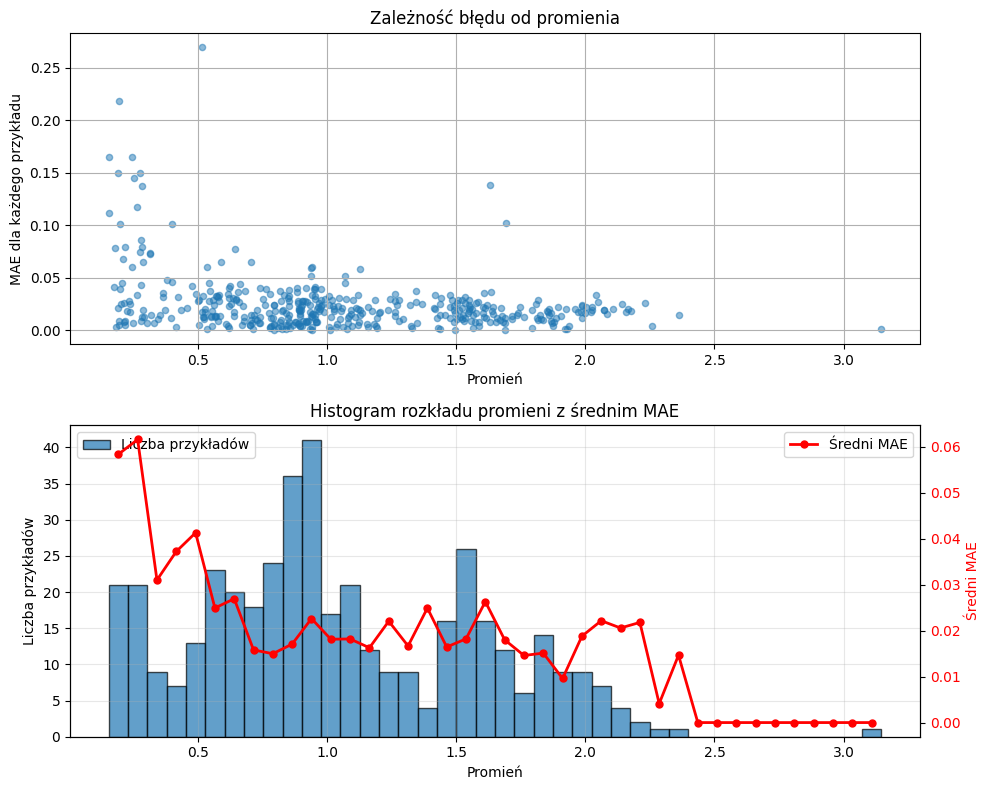

In [ ]:
# Predykcja modelu na zbiorze walidacyjnym
y_pred_val = model.predict(X_val)

# Obliczenie błędu dla każdego przykładu (wartość bezwzględna różnicy)
mae_per_sample_val = np.abs(y_pred_val - y_val).flatten()

# Ponieważ train_test_split nie zwraca indeksów, użyjemy całego zbioru
# i zrobimy predykcję na wszystkich danych
y_pred_all = model.predict(inputs0)
mae_per_sample_all = np.abs(y_pred_all - kolowosc).flatten()
promien_all = promien.flatten()

# Wykresy zależności błędu od promienia
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Lewy subplot - scatter plot
axes[0].scatter(promien_all, mae_per_sample_all, alpha=0.5, s=20)
axes[0].set_xlabel('Radius')
axes[0].set_ylabel('MAE for each example')
axes[0].set_title('Relationship of error to radius')
axes[0].grid(True)

# Prawy subplot - histogram z linią
n, bins, patches = axes[1].hist(promien_all, bins=40, edgecolor='black', alpha=0.7, label='Liczba przykładów')

# Obliczenie średniego MAE dla każdego bina
bin_centers = (bins[:-1] + bins[1:]) / 2
mae_means = []
for i in range(len(bins)-1):
    mask = (promien_all >= bins[i]) & (promien_all < bins[i+1])
    if mask.sum() > 0:
        mae_means.append(mae_per_sample_all[mask].mean())
    else:
        mae_means.append(0)

# Oś wtórna dla MAE
ax2 = axes[1].twinx()

# MAE line on secondary Y axis
ax2.plot(bin_centers, mae_means, 'r-o', linewidth=2, markersize=5, label='Average MAE')
ax2.set_ylabel('Average MAE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

axes[1].set_xlabel('Radius')
axes[1].set_ylabel('Number of examples')
axes[1].set_title('Histogram of radius distribution with average MAE')
axes[1].grid(True, alpha=0.3)

# Legendy
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()

Trenowanie modelu z różnymi batch_size
======================================================================

Trenowanie z batch_size = 1...
✓ Batch size  1 - Val MAE: 0.032434

Trenowanie z batch_size = 2...
✓ Batch size  2 - Val MAE: 0.029472

Trenowanie z batch_size = 4...
✓ Batch size  4 - Val MAE: 0.033367

Trenowanie z batch_size = 8...
✓ Batch size  8 - Val MAE: 0.033732

Trenowanie z batch_size = 16...
✓ Batch size 16 - Val MAE: 0.049636

Trenowanie z batch_size = 32...
✓ Batch size 32 - Val MAE: 0.040843

Trenowanie z batch_size = 64...
✓ Batch size 64 - Val MAE: 0.046812

======================================================================
🏆 Najlepszy batch_size: 2
   Val MAE: 0.029472

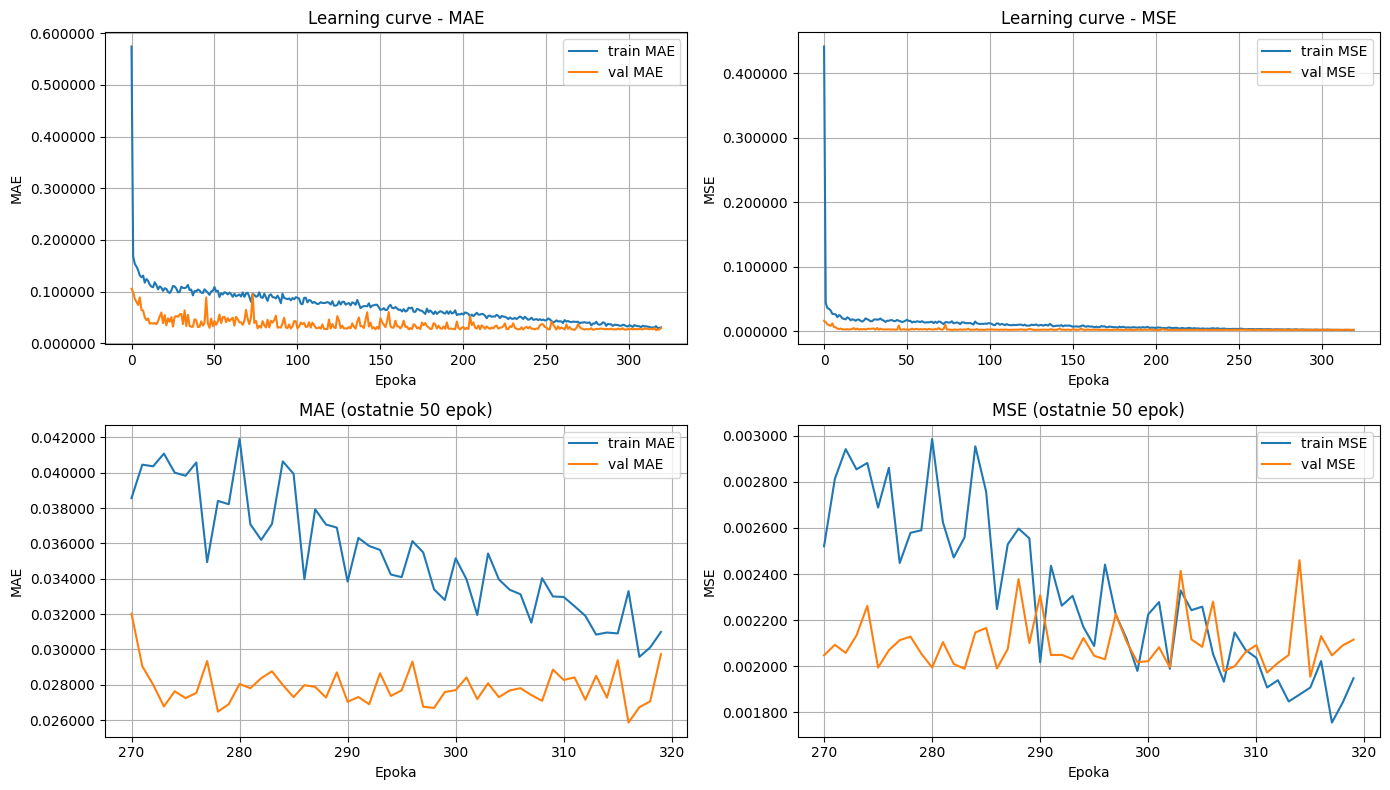

In [ ]:
import matplotlib.pyplot as plt


# Wizualizacja krzywych trenowania
plt.figure(figsize=(14,8))

# Górny rząd - wszystkie epoki
plt.subplot(2,2,1)
plt.plot(history.history['mae'], label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.title('Learning curve - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.6f}'))

plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history.history['mse'], label='train MSE')
plt.plot(history.history['val_mse'], label='val MSE')
plt.title('Learning curve - MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.6f}'))

plt.legend()
plt.grid(True)

# Dolny rząd - ostatnie 50 epok
plt.subplot(2,2,3)
epochs_range = range(len(history.history['mae']) - 50, len(history.history['mae']))
plt.plot(epochs_range, history.history['mae'][-50:], label='train MAE')
plt.plot(epochs_range, history.history['val_mae'][-50:], label='val MAE')
plt.title('MAE (last 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.6f}'))

plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
epochs_range = range(len(history.history['mse']) - 50, len(history.history['mse']))
plt.plot(epochs_range, history.history['mse'][-50:], label='train MSE')
plt.plot(epochs_range, history.history['val_mse'][-50:], label='val MSE')
plt.title('MSE (last 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.6f}'))

plt.legend()
plt.grid(True)

plt.tight_layout()




In [17]:
# Podsumowanie wyników treningowych
print("=" * 60)
print("TRAINING RESULTS SUMMARY")
print("=" * 60)

# Accuracy (based on MAE and data range)
target_range = kolowosc.max() - kolowosc.min()
accuracy_train = (1 - (history.history['mae'][-1] / target_range)) * 100
accuracy_val = (1 - (history.history['val_mae'][-1] / target_range)) * 100

print("\n EVALUATION (based on MAE):")
print(f"  Train: {accuracy_train:.2f}%")
print(f"  Val:   {accuracy_val:.2f}%")

# Overfitting/Underfitting
val_train_diff = history.history['val_loss'][-1] - history.history['loss'][-1]
print("\n  GENERALIZATION:")
if val_train_diff > 0.001:
    print(f"  Trend: OVERFITTING (Val loss > Train loss, difference: {val_train_diff:.6f})")
elif val_train_diff < -0.001:
    print(f"  Trend: UNDERFITTING (Val loss < Train loss, difference: {val_train_diff:.6f})")
else:
    print(f"  Trend: BALANCED (Val loss ≈ Train loss, difference: {val_train_diff:.6f})")


# Number of epochs
print(f"\n  NUMBER OF EPOCHS: {len(history.history['loss'])}")

# MAE
print(f"\n MAE for validation set: {history.history['val_mae'][-1]}")

print("=" * 60)

TRAINING RESULTS SUMMARY

 EVALUATION (based on MAE):
  Train: 91.23%
  Val:   91.58%

  GENERALIZATION:
  Trend: UNDERFITTING (Val loss < Train loss, difference: -0.001258)

  NUMBER OF EPOCHS: 320

 MAE for validation set: 0.029732869938015938


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
-0.0051077222


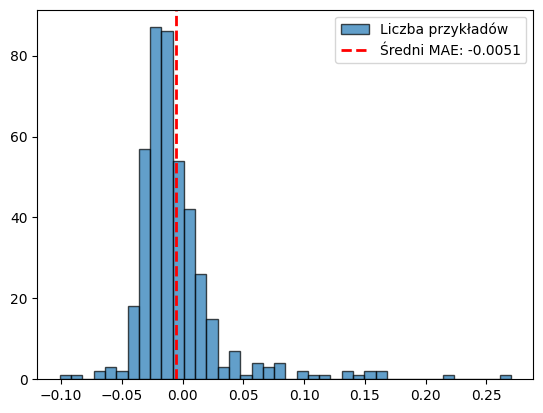

In [ ]:

y_pred_all = model.predict(inputs0)
blad_kolowosc = (y_pred_all - kolowosc).flatten()

# Histogram
plt.hist(blad_kolowosc, bins=40, edgecolor='black', alpha=0.7, label='Number of examples')

# Average MAE line
srednia_mae = np.mean(blad_kolowosc)
plt.axvline(srednia_mae, color='red', linestyle='--', linewidth=2, label=f'Average MAE: {srednia_mae:.4f}')
plt.legend()

print(np.mean(blad_kolowosc))